# import data and modules

In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
# import graphviz
from matplotlib import pyplot
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import codecs  
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import stats
import matplotlib.pyplot as plt
# %matplotlib inline

def plot_roc_curve(y, y_pred, gini, ks, filename):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, 'b--', label='%s AUC = %0.4f, GINI = %0.2f, KS = %0.2f' % ('Model: ', roc_auc, gini, ks))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(filename)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.savefig(filename + '.png',dpi = 1200)
    plt.show()

In [86]:
def output_prediction(df,model,y_encoder,filename):
    if 'Loan_Status' in df.columns:
        del df['Loan_Status']
    df['Loan_Status'] = y_encoder.inverse_transform(np.where(model.predict(df),1,0))
    df['Loan_Status'].to_csv('./data/'+ filename + '.csv',header = True)

In [87]:
train = pd.read_csv("./data/train.csv",index_col= 0)
test = pd.read_csv('./data/test.csv',index_col = 0)

# data cleaning

## descriptive statistics

In [88]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, LP001015 to LP002989
Data columns (total 11 columns):
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 34.4+ KB


注意到，测试集和训练集的缺失情况不一样，具体来说训练集有缺失的变量和测试集有缺失的变量不完全相同。另外，训练集和测试集在同一个变量上的取值可能不一样。所以如何进行缺失值的插补 以及 特征的编码呢？顺序应该是先进行插补，然后进行编码。

In [91]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [92]:
train.columns[train.dtypes == 'object'].values

array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'], dtype=object)

In [93]:
train.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [94]:
imbalance_ratio = sum(train.Loan_Status == 'N') / sum(train.Loan_Status == 'Y')

## 插补

In [95]:
X = train.drop('Loan_Status',axis = 1)
y = train.Loan_Status
X.shape,y.shape

((614, 11), (614,))

### 均值插补，众数插补，交叉表插补

In [96]:
pd.crosstab(X['Married'], (X['CoapplicantIncome']==0))

CoapplicantIncome,False,True
Married,,
No,70,143
Yes,270,128


In [97]:
X.loc[(X['Married'].isnull()) & (X['CoapplicantIncome']==0), 'Married'] = 'No'
X.loc[(X['Married'].isnull()), 'Married'] = 'Yes'

In [98]:
pd.crosstab(X['Gender'], (X['Married']=='Yes') & (X['ApplicantIncome']>X['CoapplicantIncome']))

col_0,False,True
Gender,,
Female,86,26
Male,180,309


In [99]:
a=((X['Gender'].isnull()) & (X['Married']=='Yes') & (X['ApplicantIncome']>X['CoapplicantIncome']))
X.loc[a, 'Gender'] = 'Male'
X.loc[X['Gender'].isnull(),'Gender'] = 'Female'

In [100]:
a=((test['Gender'].isnull()) & (test['Married']=='Yes') & (test['ApplicantIncome']>test['CoapplicantIncome']))
test.loc[a, 'Gender'] = 'Male'
test.loc[test['Gender'].isnull(),'Gender'] = 'Female'

In [101]:
mmodus = ['Gender','Married','Self_Employed','Dependents','Credit_History','Property_Area','Education']
mmean = ['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term']

In [102]:
for feature in mmean:
        if feature in X.columns.values:
            X[feature] = X[feature].fillna(X[feature].mean())
            test[feature] = test[feature].fillna(test[feature].mean())
            
for feature in mmodus:
        if feature in X.columns.values:
            X[feature] = X[feature].fillna(X[feature].value_counts().index[0])
            le = preprocessing.LabelEncoder()
            X.loc[:,feature] = le.fit_transform(X.loc[:,feature].astype('str')) 
            
            test[feature] = test[feature].fillna(test[feature].value_counts().index[0])
            le = preprocessing.LabelEncoder()
            test.loc[:,feature] = le.fit_transform(test.loc[:,feature].astype('str')) 

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

## 探究缺失的规律，使用模型做插补

In [ ]:
X.Credit_History = X.Credit_History.astype('object')
test.Credit_History = test.Credit_History.astype('object')

In [ ]:
num_feat = X.columns[X.dtypes != 'object'].values

In [ ]:
cate_feat = X.columns[X.dtypes == 'object'].values

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
X_new = X.copy()
test_new = test.copy()
for col_name in cate_feat:
    print(col_name)
    le = preprocessing.LabelEncoder()
    temp_value = le.fit_transform(X.loc[:,col_name].astype('str')) 
    X_new.loc[:,col_name] = np.where(X.loc[:,col_name].isna(),np.nan,temp_value)
    print(X.loc[:,col_name].value_counts(dropna = False))
    temp_value = le.transform(test.loc[:,col_name].astype('str')) 
    test_new.loc[:,col_name] = np.where(test.loc[:,col_name].isna(),np.nan,temp_value)

In [ ]:
train.Gender.value_counts(dropna = False)

In [ ]:
test.Gender.value_counts(dropna = False)

In [ ]:
X.info()

In [ ]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
# le.inverse_transform(y)

## feature engineering

In [103]:
X['TotalIncome']=X['ApplicantIncome']+X['CoapplicantIncome']
X['Loan/Income']=X['LoanAmount']/X['TotalIncome']
X['Loan/Term']=X['LoanAmount']/X['Loan_Amount_Term']
X['RepaymentRatio']=(X['Loan/Term']*1000)/X['TotalIncome']

In [104]:
test['TotalIncome']=test['ApplicantIncome']+test['CoapplicantIncome']
test['Loan/Income']=test['LoanAmount']/test['TotalIncome']
test['Loan/Term']=test['LoanAmount']/test['Loan_Amount_Term']
test['RepaymentRatio']=(test['Loan/Term']*1000)/test['TotalIncome']

In [105]:
transformation=preprocessing.StandardScaler().fit(X[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']])
X[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']]= \
transformation.transform(X[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']])

test[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']]= \
transformation.transform(test[['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','Loan_Amount_Term']])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


考虑进行编码和分箱，目前来看onehot编码并不能有改善，对连续变量进行分箱，可能可以提升LR的稳健性，具体如何分箱，可以查看金融风控实战的课程。

In [164]:
feat_need_onehot = list(X.columns.values[(X.nunique() - test.nunique()) == 0])

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area']

如果同一个变量，在测试集中取值比在训练集中更多，这会给编码带来不便。可以把新出现的值标记为缺失，也可以把训练集+测试集用于编码。

In [200]:
onehot = preprocessing.OneHotEncoder(categories='auto',sparse=False)
new_data = pd.DataFrame(onehot.fit_transform(X[feat_need_onehot]),\
                        index=X.index,columns = onehot.get_feature_names(feat_need_onehot))
X_onehot = pd.concat([X,new_data],axis = 1).drop(labels = feat_need_onehot,axis = 1)

In [204]:
new_data = pd.DataFrame(onehot.fit_transform(test[feat_need_onehot]),\
                        index=test.index,columns = onehot.get_feature_names(feat_need_onehot))
test_onehot = pd.concat([test,new_data],axis = 1).drop(labels = feat_need_onehot,axis = 1)

In [206]:
X_onehot.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,TotalIncome,Loan/Income,Loan/Term,RepaymentRatio,Gender_0,Gender_1,...,Dependents_3,Education_0,Education_1,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001002,0.072991,-0.554487,0.000000,0.279851,-0.182184,0.025032,0.406700,0.069533,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
LP001003,-0.134412,-0.038732,-0.219273,0.279851,-0.144684,0.021015,0.355556,0.058374,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
LP001005,-0.393747,-0.554487,-0.957641,0.279851,-0.623656,0.022000,0.183333,0.061111,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
LP001006,-0.462062,0.251980,-0.314547,0.279851,-0.322885,0.024287,0.333333,0.067463,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
LP001008,0.097728,-0.554487,-0.064454,0.279851,-0.158785,0.023500,0.391667,0.065278,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [207]:
test_onehot.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,TotalIncome,Loan/Income,Loan/Term,RepaymentRatio,Gender_0,Gender_1,...,Dependents_3,Education_0,Education_1,Self_Employed_0,Self_Employed_1,Credit_History_0,Credit_History_1,Property_Area_0,Property_Area_1,Property_Area_2
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001015,0.051857,-0.554487,-0.433638,0.279851,-0.202173,0.019231,0.305556,0.053419,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
LP001022,-0.381297,-0.041468,-0.243092,0.279851,-0.379444,0.027535,0.350000,0.076486,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
LP001031,-0.066097,0.061136,0.733459,0.279851,-0.034820,0.030588,0.577778,0.084967,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
LP001035,-0.501872,0.316278,-0.552730,0.279851,-0.331407,0.020467,0.277778,0.056852,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
LP001051,-0.348532,-0.554487,-0.814731,0.279851,-0.580888,0.023810,0.216667,0.066138,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# modeling

In [106]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1223)
X_train.shape,X_test.shape

((429, 15), (185, 15))

In [205]:
X_train,X_test,y_train,y_test = train_test_split(X_onehot,y,test_size = 0.3,random_state = 1223)
X_train.shape,X_test.shape

((429, 25), (185, 25))

## logistic regression

### L2 with C = 1

In [219]:
LR_model = LogisticRegression(class_weight='balanced',C=0.8,penalty='l2')
LR_model.fit(X_train,y_train)
print(LR_model.score(X_test,y_test))
output_prediction(test_onehot,LR_model,le,'LR_C_1')
y_pred = LR_model.predict(X_test)
y_pred_prob_1 = LR_model.predict_proba(X_test)[:,1] 

0.7621621621621621


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### L2 with C =2 

In [220]:
LR_model = LogisticRegression(class_weight='balanced',C=2,penalty='l2')
LR_model.fit(X_train,y_train)
print(LR_model.score(X_test,y_test))
output_prediction(test,LR_model,le,'LR_C_2')
y_pred = LR_model.predict(X_test)
y_pred_prob_1 = LR_model.predict_proba(X_test)[:,1] 

0.7675675675675676


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: X has 15 features per sample; expecting 25

### L1 with C =1, then L2 C =1 

In [62]:
LR_model = LogisticRegression(class_weight='balanced',C=1,penalty='l1')
LR_model.fit(X,y)
output_prediction(test,LR_model,le,'LR_C_1')
feat_selected = list(X.columns.values[abs(LR_model.coef_[0]) > 0])
print(feat_selected)
LR_model = LogisticRegression(class_weight='balanced',C=0.2)
LR_model.fit(X.loc[:,feat_selected],y)
output_prediction(test.loc[:,feat_selected],LR_model,le,'LR_L1_C_1_L2_C_1')
y_pred = LR_model.predict(X_test.loc[:,feat_selected])
y_pred_prob_1 = LR_model.predict_proba(X_test.loc[:,feat_selected])[:,1] 

['Gender', 'Married', 'Dependents', 'Education', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'RepaymentRatio']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### L2 CV, Cs = 10

In [69]:
LR_cv = LogisticRegressionCV(class_weight='balanced')
LR_cv.fit(X,y)
print(LR_cv.C_)
output_prediction(test,LR_cv,le,'LR_Cs10')
y_pred = LR_cv.predict(X_test)
y_pred_prob_1 = LR_cv.predict_proba(X_test)[:,1] 

[21.5443469]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [108]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob_1,drop_intermediate=False)

In [109]:
print('AUC:{0:.4f}\nKS :{1:.4f}\nACC:{2:.4f}'.format(roc_auc_score(y_test,y_pred_prob_1),max(tpr - fpr),LR_cv.score(X_test,y_test)))

AUC:0.7684
KS :0.5496
ACC:0.8162


In [110]:
confusion_matrix(y_test,y_pred)

array([[ 34,  23],
       [  7, 121]], dtype=int64)

GINI = 0.5367324561403508, KS = 0.45161290322580644


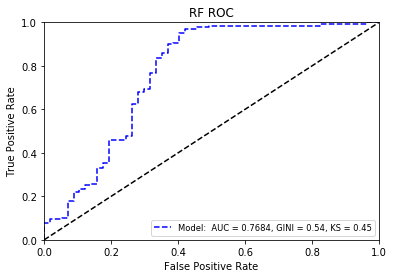

In [111]:
gini = 2 * roc_auc_score(y_test, y_pred_prob_1) - 1
ks = stats.ks_2samp(tpr,fpr).statistic
print('GINI = %s, KS = %s' % (gini, ks))
plot_roc_curve(y_test, y_pred_prob_1, gini, ks,'RF ROC')

f1=0.873 auc=0.860 ap=0.861


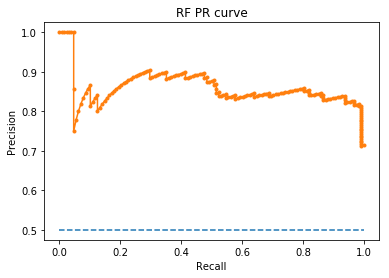

In [89]:
# precision-recall curve and f1
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_1)
# calculate F1 score
f1 = f1_score(y_test, y_pred)
# calculate precision-recall AUC
rf_auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, y_pred_prob_1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, rf_auc, ap))
# plot no skill
plt.figure(figsize=(6,4))
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
plt.title('RF PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the plot
plt.savefig('RF_PR_curve.png',dpi = 1200)
pyplot.show()

从以上结果来看，cv能够让模型充分利用已有的数据，但是在小数据集的情况下，会出现过拟合的情况，从而在B榜效果不佳。需要加大模型的惩罚，不一定需要追求极致的A榜成绩。可以尝试LOO，以及数据扩充的方式。

## random foreast

In [221]:
rf = RandomForestClassifier(class_weight='balanced',max_depth=4, random_state=0,n_estimators=1000,n_jobs = 8, verbose = 1)

In [222]:
rf.fit(X_train,y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=8, oob_score=False, random_state=0,
            verbose=1, warm_start=False)

In [223]:
rf.score(X_test,y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.8216216216216217

In [224]:
roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.8067434210526316

In [226]:
output_prediction(test_onehot,rf,le,'rf')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished


## xgboost

### fitting

In [227]:
xg_reg = xgb.XGBClassifier(silent=False,
                           scale_pos_weight=imbalance_ratio,
                           learning_rate=0.05,
                           colsample_bytree=0.8,
                           subsample=0.8,
                           objective='binary:logistic',
                           n_estimators=2000,
                           reg_alpha=0.3,
                           max_depth=4,
                           gamma=5,
                           eval_metric=["error",'aucpr'],
#                            tree_method='gpu_hist', predictor='gpu_predictor',
                           n_jobs = -1)

In [35]:
xg_reg.fit(X_train,y_train)

[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 

[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[01:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric=['error', 'aucpr'], gamma=5,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=0.4549763033175355,
       seed=None, silent=False, subsample=0.8)

### fitting using eval set 

In [237]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["error",'auc']
xg_reg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True,early_stopping_rounds= 20)

[21:18:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[0]	validation_0-error:0.179487	validation_0-auc:0.729504	validation_1-error:0.167568	validation_1-auc:0.771039
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[21:18:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[1]	validation_0-error:0.181818	validation_0-auc:0.78773	validation_1-error:0.167568	validation_1-auc:0.816817
[21:18:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[2]	validation_0-error:0.181818	validation_0-auc:0.78773	validation_1-error:0.167568	validation_1-auc:0.816817
[21:18:43] C:\Users\Administrator\Desktop\xgboost\src\tree\

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric=['error', 'aucpr'], gamma=5,
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=0.4549763033175355,
       seed=None, silent=False, subsample=0.8)

In [238]:
xg_reg.score(X_test,y_test)

0.8324324324324325

In [239]:
y_pred = xg_reg.predict(X_test)
y_pred_prob_1 = xg_reg.predict_proba(X_test)[:,1] 

In [240]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob_1,drop_intermediate=False)

In [241]:
print('AUC:{0}\nKS:{1}\nACC :{2}'.format(roc_auc_score(y_test,y_pred_prob_1),max(tpr - fpr),xg_reg.score(X_test,y_test)))

AUC:0.822779605263158
KS:0.5242598684210527
ACC :0.8324324324324325


In [242]:
confusion_matrix(y_test,y_pred)

array([[ 33,  24],
       [  7, 121]], dtype=int64)

GINI = 0.6455592105263159, KS = 0.5714285714285714


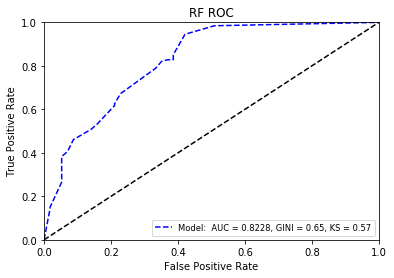

In [243]:
gini = 2 * roc_auc_score(y_test, y_pred_prob_1) - 1
ks = stats.ks_2samp(tpr,fpr).statistic
print('GINI = %s, KS = %s' % (gini, ks))
plot_roc_curve(y_test, y_pred_prob_1, gini, ks,'RF ROC')

f1=0.886 auc=0.896 ap=0.887


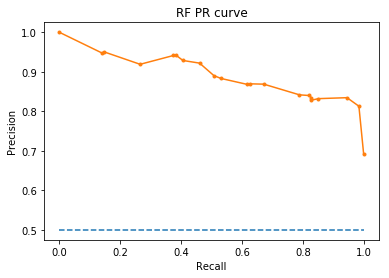

In [244]:
# precision-recall curve and f1
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_1)
# calculate F1 score
f1 = f1_score(y_test, y_pred)
# calculate precision-recall AUC
rf_auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, y_pred_prob_1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, rf_auc, ap))
# plot no skill
plt.figure(figsize=(6,4))
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
plt.title('RF PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the plot
plt.savefig('RF_PR_curve.png',dpi = 1200)
pyplot.show()

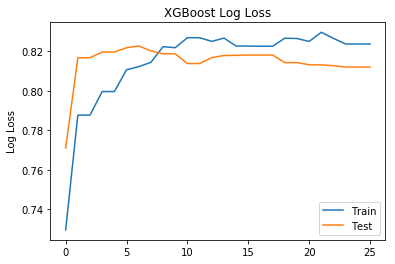

In [245]:
model = xg_reg
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(6,4))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
plt.savefig('log_loss.png',dpi = 1200)
pyplot.show()

### grid search CV = 5

In [252]:
param_test = {
    'max_depth': [5,6,7],
    'gamma': [1, 2, 5],
    'reg_alpha': [0.1, 0.3, 0.5],
    'subsample': [0.5, 0.6, 0.7, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'n_estimators': [100],
    'learning_rate': [0.01,0.02,0.05],
    'early_stopping_rounds': [20]
}

gsearch = GridSearchCV(estimator=xgb.XGBRegressor(
    booster='gbtree',
    objective='binary:logistic',
    eval_metric=["error"],
#     tree_method='gpu_hist',
#     predictor='gpu_predictor',
    n_jobs=-1,
    scale_pos_weight=imbalance_ratio,
    min_child_weight=1.1,
    seed=27,),
    param_grid=param_test,
    iid=False,
    cv=10,
    verbose=2)
gsearch.fit(X_onehot, y)

Fitting 10 folds for each of 972 candidates, totalling 9720 fits
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.5, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.6, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=1, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=5, n

[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=2, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=5, n

[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.01, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=5, n

[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.02, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.1, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.3, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n_estimators=100, reg_alpha=0.5, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=5, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.1, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=6, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.1, subsample=0.7 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.3, subsample=0.6 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.5 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8, total=   0.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n_estimators=100, reg_alpha=0.5, subsample=0.8 
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, gamma=5, learning_rate=0.05, max_depth=7, n

[Parallel(n_jobs=1)]: Done 9720 out of 9720 | elapsed:  9.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric=['error'], gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1.1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.4549763033175355,
       seed=27, silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'max_depth': [5, 6, 7], 'gamma': [1, 2, 5], 'reg_alpha': [0.1, 0.3, 0.5], 'subsample': [0.5, 0.6, 0.7, 0.8], 'colsample_bytree': [0.5, 0.6, 0.7], 'n_estimators': [100], 'learning_rate': [0.01, 0.02, 0.05], 'early_stopping_rounds': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [256]:
gsearch.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, early_stopping_rounds=20,
       eval_metric=['error'], gamma=1, learning_rate=0.05,
       max_delta_step=0, max_depth=7, min_child_weight=1.1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.1,
       reg_lambda=1, scale_pos_weight=0.4549763033175355, seed=27,
       silent=True, subsample=0.5)

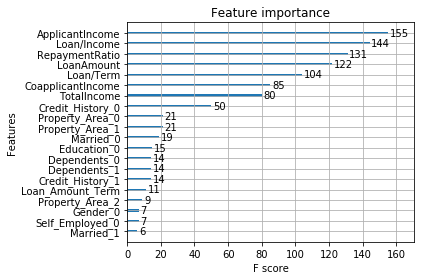

In [253]:
%matplotlib inline
xgb.plot_importance(gsearch.best_estimator_,max_num_features=20)
plt.tight_layout()
plt.savefig('grid_search_xgb.png',dpi = 1200)

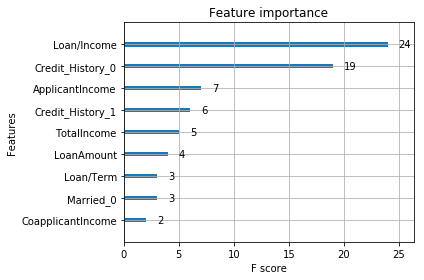

In [254]:
%matplotlib inline
xgb.plot_importance(xg_reg,max_num_features=20)
plt.tight_layout()
plt.savefig('xgb.png',dpi = 1200)

# predicting

In [255]:
output_prediction(test_onehot,xg_reg,le,'xgb_eval')
output_prediction(test_onehot,gsearch.best_estimator_,le,'xgb_cv')

## 模型融合

In [52]:
if 'Loan_Status' in test.columns:
        del test['Loan_Status']
LR_score = LR_model.predict_proba(test)[:,1]
RF_score = rf.predict_proba(test)[:,1]
XGB_score = xg_reg.predict_proba(test)[:,1]
a,b,c = LR_model.score(X_test,y_test),rf.score(X_test,y_test),xg_reg.score(X_test,y_test)
merge_scores = (np.exp(a)*LR_score + np.exp(b)*RF_score + np.exp(c)*XGB_score)/ \
(np.exp(a)+ np.exp(b)+np.exp(c))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


In [53]:
test['Loan_Status'] = le.inverse_transform(np.where(merge_scores > 0.5,1,0))
test['Loan_Status'].to_csv('./data/'+ 'LR+RF+XGB' + '.csv',header = True)

想要观察一下三个模型分类错误的训练集样本是什么样子的？做一下数据分析，查看这些样本和其他样本区别在哪里？测试集中如果有和它们比较相似的样本，就反向预测，这种人工添加规则的做法是否合理？

In [87]:
LR_predict = LR_model.predict(X)
RF_predict = rf.predict(X)
XGB_predict = xg_reg.predict(X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [90]:
train.loc[(LR_predict != y) & (RF_predict != y) & (XGB_predict != y)]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
LP001029,Male,No,0,Graduate,No,1853,2840.0,114.0,360.0,1.0,Rural,N
LP001038,Male,Yes,0,Not Graduate,No,4887,0.0,133.0,360.0,1.0,Rural,N
LP001052,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,NaN,Semiurban,N
LP001091,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,NaN,Urban,N
LP001095,Male,No,0,Graduate,No,3167,0.0,74.0,360.0,1.0,Urban,N
LP001097,Male,No,1,Graduate,Yes,4692,0.0,106.0,360.0,1.0,Rural,N
LP001119,Male,No,0,Graduate,No,3600,0.0,80.0,360.0,1.0,Urban,N
